In [38]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
)
from ripple_heterogeneity.readout import pairwise_ccgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [49]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


In [114]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccgs_readout_v3"
    )

batch_analysis.run(
    df_sessions,
    save_path,
    pairwise_ccgs.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
label_df, ccgs = pairwise_ccgs.load_results(save_path)

100%|██████████| 110/110 [01:58<00:00,  1.08s/it]


In [120]:
from scipy.ndimage import gaussian_filter1d


def plot_psth_matrix(
    psth_df, label=None, ax=None, vmax=3, vmin=-3,smoothing=True
):

    psth = psth_df.values
    
    psth = psth[:,~np.isnan(psth).any(axis=0)]
    if smoothing:
        psth_smooth = gaussian_filter1d(
            psth, np.round(0.020 / np.diff(psth_df.index)[0]), axis=0
        )
    else:
        psth_smooth = psth
    # psth_smooth = psth
    max_mean_ratio = psth_smooth[(psth_df.index > 0) & (psth_df.index < 0.1), :].max(
        axis=0
    ) / psth_smooth[(psth_df.index < -0.10), :].mean(axis=0)

    sort_idx = np.argsort(max_mean_ratio)

    if ax is None:
        plt.figure()
    ax = plt.gca()

    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    sm = ax.imshow(
        stats.zscore(psth_smooth, axis=0)[:, sort_idx].T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr",
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm
    
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper
    
def std_upper_lower(X):
    upper = np.nanmean(X,axis=1) + np.nanstd(X,axis=1)
    lower = np.nanmean(X,axis=1) - np.nanstd(X,axis=1)
    return lower,upper

def get_center_val(psth_df, window=[0,0.05], smooth_sigma=0.02):
    # find cells within region
    psth = psth_df.values
    # standardize psth
    psth = stats.zscore(psth, axis=0)
    # smooth over time
    psth_smooth = gaussian_filter1d(
        psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
    )
    # pull out data within time window
    X = psth_smooth[(psth_df.index > window[0]) & (psth_df.index < window[1]), :]
    # find center value of each cell, can be positive or negative, but will be max magnitude
    center_val = [X[np.argmax(np.abs(X[:,i])),i] for i in range(X.shape[1])]
    return np.array(center_val)

def plot_psth_postive_negative(psth_df, group_label, group_colors, ax0):

    center_val = get_center_val(psth_df)

    # plot positive psth responses
    psth = psth_df.values
    psth = psth[:,center_val > 0]
    psth = stats.zscore(psth, axis=0)
    lower,upper= confidence_intervals(psth.T)
    ax0.plot(psth_df.index,np.nanmean(psth,axis=1),color=group_colors[group_label],linewidth=1)
    ax0.fill_between(psth_df.index, lower, upper, color=group_colors[group_label], alpha = .5, linewidth = 0)

    # plot negative psth responses
    psth = psth_df.values
    psth = psth[:,center_val < 0]
    psth = stats.zscore(psth, axis=0)
    lower,upper= confidence_intervals(psth.T)
    ax0.plot(psth_df.index,np.nanmean(psth,axis=1),color=group_colors[group_label],linewidth=1)
    ax0.fill_between(psth_df.index, lower, upper, color=group_colors[group_label], alpha = .5, linewidth = 0)



In [116]:
label_df.loc[label_df.ref_region.str.contains("CA1"),"ref_region"] = "CA1"
label_df.loc[label_df.target_region.str.contains("CA1"),"target_region"] = "CA1"
label_df.loc[label_df.ref_region.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"),"ref_region"] = "MEC"
label_df.loc[label_df.target_region.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"),"target_region"] = "MEC"

label_df.loc[label_df.target_region.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC"),"deepSuperficial_target"] = "Unknown"
label_df.loc[label_df.ref_region.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC"),"deepSuperficial_ref"] = "Unknown"

# label_df.loc[label_df.ref_region.str.contains("CA1") & label_df.deepSuperficial_ref.str.contains("CA1"),"label"] = 
label_df["label"] = label_df.ref_region + "_" + label_df.target_region
label_df["label"] = label_df.label.replace({"MEC_CA1":"CA1_MEC", "PFC_CA1":"CA1_PFC"})

label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_ref == "Deep"),"label"] = "deep_mec"
label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_ref == "Superficial"),"label"] = "sup_mec"

label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_target == "Deep"),"label"] = "deep_mec"
label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_target == "Superficial"),"label"] = "sup_mec"


label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_ref == "Deep"),"label"] = "deep_pfc"
label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_ref == "Superficial"),"label"] = "sup_pfc"

label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_target == "Deep"),"label"] = "deep_pfc"
label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_target == "Superficial"),"label"] = "sup_pfc"

label_df.label.unique()

array(['CA1_CA1', 'deep_mec', 'CA1_MEC', 'sup_mec', 'MEC_MEC', 'PFC_PFC',
       'sup_pfc', 'CA1_PFC', 'deep_pfc', 'PFC_MEC'], dtype=object)

In [96]:
# label_df.query("label == 'CA1_CA1'")[["deepSuperficial_ref","deepSuperficial_target"]].value_counts()

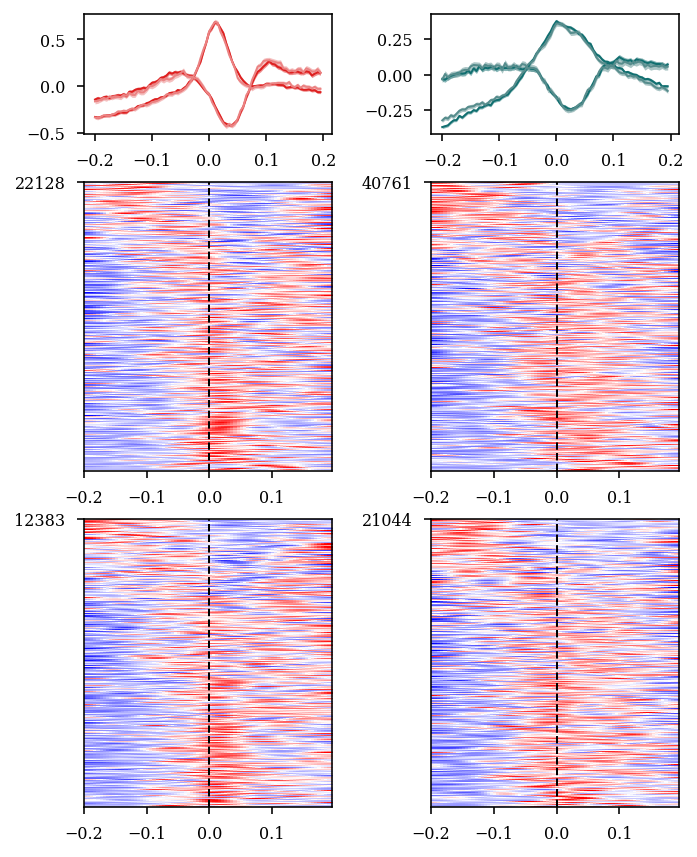

In [121]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
ccgs_restrict = ccgs.loc[(ccgs.index >=-.2) & (ccgs.index <=.2),:]

fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(4,2)),constrained_layout=False)
gs = fig.add_gridspec(nrows=5, ncols=2, left=0.05, right=0.75, hspace=0.4, wspace=0.4)

y_min = -.75
y_max = 1.25
heatmap_factor = 2

ax0 = fig.add_subplot(gs[0, 0])
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="deep_mec"], 'deep_mec', group_colors, ax0)
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="sup_mec"], 'sup_mec', group_colors, ax0)


ax1 = fig.add_subplot(gs[0, 1])
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="deep_pfc"], 'deep_pfc', group_colors, ax1)
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="sup_pfc"], 'sup_pfc', group_colors, ax1)


ax2 = fig.add_subplot(gs[1:3,0])
plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="deep_mec"], label=None, ax=ax2, vmax=3, vmin=-3)


ax3 = fig.add_subplot(gs[1:3,1])
plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="deep_pfc"], label=None, ax=ax3, vmax=3, vmin=-3)


ax4 = fig.add_subplot(gs[3:,0])
plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="sup_mec"], label=None, ax=ax4, vmax=3, vmin=-3)

ax5 = fig.add_subplot(gs[3:,1])
sm = plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="sup_pfc"], label=None, ax=ax5, vmax=3, vmin=-3)

# axs = [ax0,ax1,ax2,ax3,ax4,ax5]
# for i in range(6):
#     axs[i].set_xlim([-0.2,.2])

In [97]:
ccgs.loc[:,label_df.label=="deep_mec"]

,15,16,17,18,19,20,21,22,23,24,...,307697,307698,307699,307700,307702,307704,307706,307708,307711,307715
-0.500,0.139519,0.139519,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.904444,0.825796,0.393236,0.314589,0.039324,0.078647,0.000000,0.078647,0.275265,0.589855
-0.495,0.069759,0.000000,0.0,0.069759,0.139519,0.000000,0.000000,0.209278,0.0,0.0,...,1.376327,0.393236,0.629178,0.235942,0.039324,0.157295,0.000000,0.078647,0.117971,0.471884
-0.490,0.069759,0.000000,0.0,0.000000,0.069759,0.139519,0.000000,0.209278,0.0,0.0,...,0.629178,0.825796,0.314589,0.432560,0.039324,0.000000,0.000000,0.157295,0.432560,0.747149
-0.485,0.069759,0.000000,0.0,0.000000,0.069759,0.139519,0.069759,0.069759,0.0,0.0,...,1.769564,1.061738,0.629178,0.117971,0.157295,0.589855,0.000000,0.314589,0.196618,0.117971
-0.480,0.000000,0.139519,0.0,0.000000,0.000000,0.000000,0.000000,0.069759,0.0,0.0,...,1.061738,0.786473,0.235942,0.275265,0.117971,0.039324,0.039324,0.196618,0.353913,0.078647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.480,0.348797,0.069759,0.0,0.000000,0.069759,0.000000,0.000000,0.279037,0.0,0.0,...,1.572945,0.471884,0.196618,0.235942,0.078647,0.117971,0.000000,0.353913,0.353913,0.117971
0.485,0.000000,0.000000,0.0,0.069759,0.069759,0.069759,0.000000,0.139519,0.0,0.0,...,1.297680,1.966182,0.432560,0.471884,0.157295,0.196618,0.039324,0.235942,0.117971,0.275265
0.490,0.000000,0.139519,0.0,0.000000,0.139519,0.000000,0.000000,0.139519,0.0,0.0,...,1.022414,0.747149,0.393236,0.550531,0.275265,0.117971,0.117971,0.117971,0.117971,0.235942
0.495,0.139519,0.209278,0.0,0.000000,0.000000,0.139519,0.000000,0.000000,0.0,0.0,...,0.825796,0.471884,0.471884,0.747149,0.078647,0.078647,0.039324,0.117971,0.235942,0.235942


## testing below

In [12]:
basepath = r"Z:\Data\AYAold\AYA7\day20"
brainRegions="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC"  # brain regions to include

# load in spike data
st, cm = loading.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion=brainRegions
)

In [34]:
rip_exp_start=0.2
rip_exp_stop=0.2
ripples_df = loading.load_ripples_events(basepath)
ripples = (
    nel.EpochArray(np.array([ripples_df.peaks, ripples_df.peaks]).T)
    .expand(rip_exp_start, direction="start")
    .expand(rip_exp_stop, direction="stop")
)

In [23]:
binsize=0.005
nbins=200

In [35]:
ccgs, pairs = functions.pairwise_cross_corr(
    st[ripples].data, return_index=True, binsize=binsize, nbins=nbins
)

<AxesSubplot:>

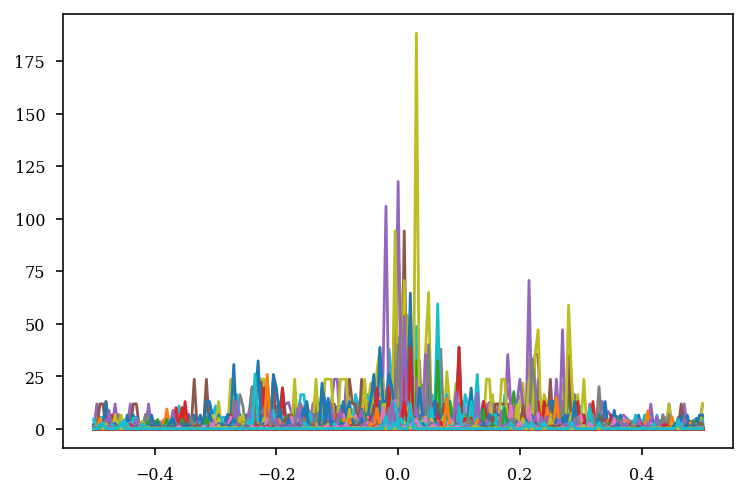

In [36]:
ccgs.plot(legend=False)